In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('../data/final_dataset.csv')

# Select relevant columns
columns = ['id', 'order_id', 'driver_id', 'driver_action', 'lat', 'lng',
       'Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time',
       'trip_duration', 'Trip Origin Lat', 'Trip Origin Lng',
       'Trip Destination Lat', 'Trip Destination Lng', 'weather', 'hour',
       'day_of_week', 'Distance_km', 'Trip Duration Hours',
       'Average Speed (km/h)', 'accepted_within_radius',
       'unfulfilled_within_radius', 'origin_cluster', 'destination_cluster']
data = data[columns]

# Take only the first 100 rows
# data = data.head(100)

# Map 'rain' to 1 and 'no rain' to 0
data['weather'] = data['weather'].map({'rain': 1, 'no-rain': 0})

# Convert the column to int type
data['weather'] = data['weather'].astype(int)
# Convert datetime columns to datetime type
data['Trip Start Time'] = pd.to_datetime(data['Trip Start Time'])
data['Trip End Time'] = pd.to_datetime(data['Trip End Time'])

# Map 'rain' to 1 and 'no rain' to 0
# data['weather'] = data['weather'].map({'rain': 1, 'no-rain': 0}).astype(int)
from sklearn.preprocessing import LabelEncoder
# Convert categorical columns to category type
categorical_columns = ['driver_action', 'Trip Origin', 'Trip Destination']
for col in categorical_columns:
    data[col] = data[col].astype('category')

# Encode categorical columns using LabelEncoder
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le



# Rename columns to remove spaces and special characters and this helps to create the StructureModel.
data.rename(columns={
    'Trip Origin Lat': 'Trip_Origin_Lat',
    'Trip Origin Lng': 'Trip_Origin_Lng',
    'Trip Destination Lat': 'Trip_Destination_Lat',
    'Trip Destination Lng': 'Trip_Destination_Lng',
    'Average Speed (km/h)': 'Average_Speed_kmph',
    'Trip Duration Hours': 'Trip_Duration_Hours'
}, inplace=True)

# Drop columns not used in the models
data = data.drop(columns=['id', 'order_id', 'driver_id', 'lat', 'lng', 'Trip Origin', 'Trip Destination', 'Trip Start Time', 'Trip End Time'])

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Define features and target variable
X_train = train_data.drop(['unfulfilled_within_radius'], axis=1)
y_train = train_data['unfulfilled_within_radius']
X_test = test_data.drop(['unfulfilled_within_radius'], axis=1)
y_test = test_data['unfulfilled_within_radius']


In [4]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Train XGBoost model

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f'XGBoost Mean Squared Error: {mse_xgb}')

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest Mean Squared Error: {mse_rf}')

XGBoost Mean Squared Error: 7.132854250612265e-10
Random Forest Mean Squared Error: 0.0


In [5]:

# Select variables based on the causal graph
selected_columns = ['Distance_km', 'Trip_Origin_Lat', 'Trip_Origin_Lng', 
                    'Trip_Destination_Lat', 'Trip_Destination_Lng', 
                    'Average_Speed_kmph', 'weather', 
                    'accepted_within_radius']

In [6]:

X_train_selected = train_data[selected_columns]
X_test_selected = test_data[selected_columns]

# Train XGBoost model with selected variables
xgb_model_selected = XGBRegressor(random_state=42)
xgb_model_selected.fit(X_train_selected, y_train)
y_pred_xgb_selected = xgb_model_selected.predict(X_test_selected)
mse_xgb_selected = mean_squared_error(y_test, y_pred_xgb_selected)
print(f'XGBoost (Selected Variables) Mean Squared Error: {mse_xgb_selected}')

# Train Random Forest model with selected variables
rf_model_selected = RandomForestRegressor(random_state=42)
rf_model_selected.fit(X_train_selected, y_train)
y_pred_rf_selected = rf_model_selected.predict(X_test_selected)
mse_rf_selected = mean_squared_error(y_test, y_pred_rf_selected)
print(f'Random Forest (Selected Variables) Mean Squared Error: {mse_rf_selected}')


XGBoost (Selected Variables) Mean Squared Error: 4.1652437929750685e-07
Random Forest (Selected Variables) Mean Squared Error: 0.0


### NB: The models  have overfitted the training data.

## Reason

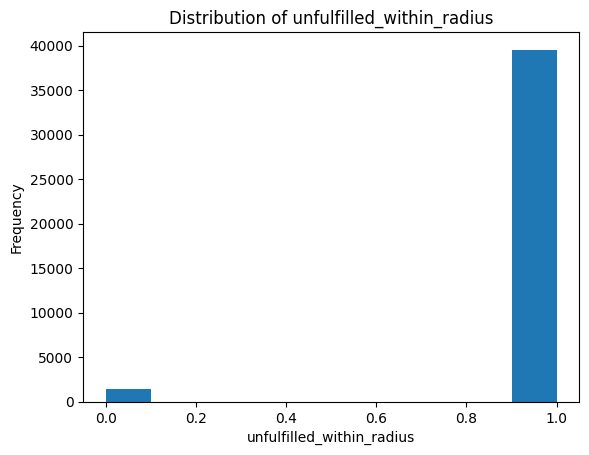

In [7]:
import matplotlib.pyplot as plt

plt.hist(data['unfulfilled_within_radius'])
plt.title('Distribution of unfulfilled_within_radius')
plt.xlabel('unfulfilled_within_radius')
plt.ylabel('Frequency')
plt.show()


The histogram indicates that the target variable unfulfilled_within_radius is highly imbalanced. The vast majority of the values are 1, with very few 0s
can be resolved by Implementing Resampling and and retrain Model 